# Part 1: Data Setup/Cleaning and Data Partitioning

In [1]:
#Import Needed Packages
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import statistics as stat
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from io import StringIO
import pydotplus
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

#read in the data
df = pd.read_csv(r'C:\Users\Home\Documents\Data Mining\Assignments\Assignment 4\HW4_FlightDelays.csv')

#drop "Weather" as it is not an ex-ante predictor
df.drop('Weather', axis=1, inplace=True)

#Group variables into a list based on type (there are no numeric variables in this data set)
cvar_list = ['Binned_CRS_DEP_TIME','CARRIER','DEST','ORIGIN','DAY_WEEK','Flight Status']

#Creating Dummies for Categorical Variables
df2 = df.copy()
df2[cvar_list] = df[cvar_list].astype('category')
df2 = pd.get_dummies(df2, prefix_sep = '_')

#Finding mode of each column so we know what redundant dummy to drop 
# I am skipping finding the mode for "flight status", as I know my event of interest is "Yes" and, as such, I will drop the "No" equivalents)
time_mode = stat.multimode(df['Binned_CRS_DEP_TIME'])
carrier_mode = stat.multimode(df['CARRIER'])
dest_mode = stat.multimode(df['DEST'])
origin_mode = stat.multimode(df['ORIGIN'])
day_mode = stat.multimode(df['DAY_WEEK'])

delay_rdummy = 'Flight Status_On-time'

#remove one "redundant dummy", per each set of dummies
rdummies = ['Binned_CRS_DEP_TIME_'+str(time_mode[0]), 'CARRIER_'+carrier_mode[0],'DEST_'+dest_mode[0],'ORIGIN_'+origin_mode[0],'DAY_WEEK_'+str(day_mode[0]),delay_rdummy]
df3 = df2.copy()
df3 = df2.drop(columns=rdummies)

#Data Partition:
#Splitting the data into our partitions will return two dataframes, so we must prep like so:
testpart_size = .2
df_partition = df3

df_nontestdata, df_testdata = train_test_split(df_partition, test_size = testpart_size, random_state = 1)

# Part 2: Create Classification Tree Over Validation Partition

The level of depth of the best pruned tree in the validation partition is 6
The AUC over the validation partition is 0.7527261704053752


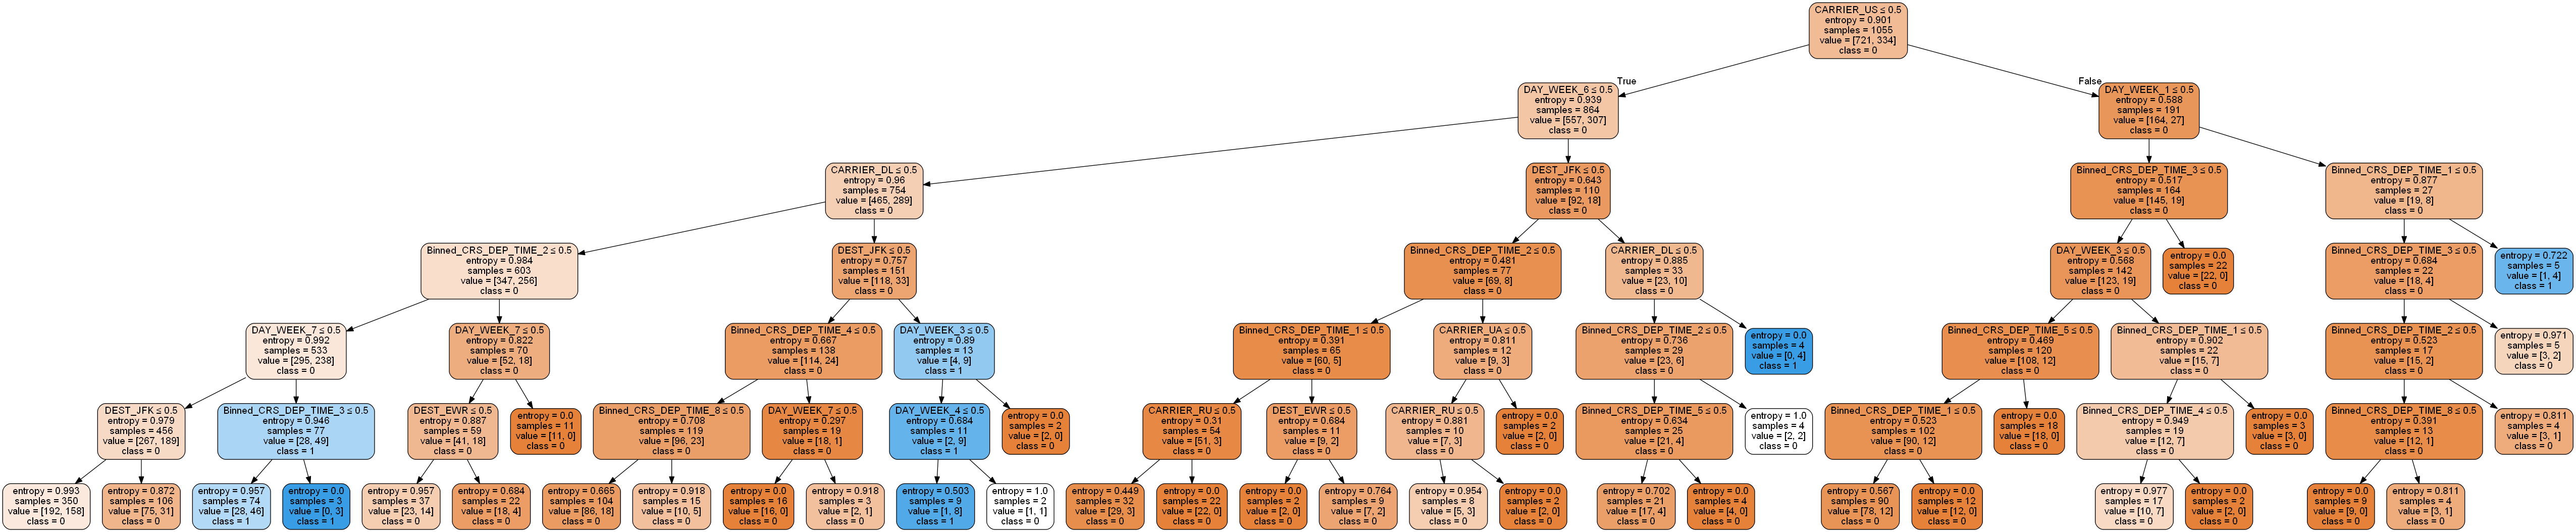

In [11]:
# Separate the predictor values and the DV values into X and y respectively
# Placeholder variable: DV
DV = 'Flight Status_Delayed'
y = df_nontestdata[DV]
X = df_nontestdata.drop(columns=[DV])

# A user-defined function summary_tree to display a classification tree
def summary_tree(model_object):
    dot_data = StringIO()
    export_graphviz(model_object, out_file=dot_data, filled=True,
                  rounded=True, special_characters=True, feature_names=X.columns.values,
                  class_names=['0', '1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    output_imagefile = 'tree.png'
    graph.write_png(output_imagefile)
    return output_imagefile

# Run Classification tree with k-fold cross validation with k=5
# Placeholder variable: kfolds
kfolds = 5

# Here we specify within which range of depths we will search for the best pruned tree
maximum_depth = 8
minimum_depth = 1

param_grid = {'max_depth': list(range(minimum_depth, maximum_depth+1))}

# Set n_jobs to be -1 to run  on all CPU cores.
# The search criterion is to find the model that maximizes whatever the scoring function - for this case roc_auc - returns.
gridsearch = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=1), param_grid, scoring='roc_auc', cv=kfolds, n_jobs=-1)
gridsearch.fit(X,y)
clf_BPT = gridsearch.best_estimator_

# Display the level of depth of the best pruned tree
print("The level of depth of the best pruned tree in the validation partition is",clf_BPT.get_depth())

# y_nontest_actual is the actual values of the DV in the validation partition
y_nontest_actual = df_nontestdata[DV]

# X_nontest is the predictor values in the validation partition
X_nontest = df_nontestdata.drop(columns=[DV])

# Get the AUC of the best pruned tree model in the validation partition
print("The AUC over the validation partition is",roc_auc_score(y_nontest_actual, clf_BPT.predict_proba(X_nontest)[:,1]))

# Display the resulting best pruned tree. Notice the capital I
Image(summary_tree(clf_BPT))

In [13]:
#Lay out tree leaf path explicitly
import numpy as np

# The user-defined function for getting the tree path
# Author: Federico Ibba on stackoverflow.com 
# Created date: Jan 19, 2018
# URL: https://stackoverflow.com/questions/32506951/how-to-explore-a-decision-tree-built-using-scikit-learn/35911666
# Modified by Lin Hao during Oct. 2020

def get_treepaths(dtc, df):
    rules_list = []
    values_path = []
    values = dtc.tree_.value

    def RevTraverseTree(tree, node, rules, pathValues):
        try:
            prevnode = tree[2].index(node)           
            leftright = '<='
            pathValues.append(values[prevnode])
        except ValueError:
            # failed, so find it as a right node - if this also causes an exception, something's really f'd up
            prevnode = tree[3].index(node)
            leftright = '>'
            pathValues.append(values[prevnode])

        # now let's get the rule that caused prevnode to -> node
        p1 = df.columns[tree[0][prevnode]]    
        p2 = tree[1][prevnode]    
        rules.append(str(p1) + ' ' + leftright + ' ' + str(p2))

        # if we've not yet reached the top, go up the tree one more step
        if prevnode != 0:
            RevTraverseTree(tree, prevnode, rules, pathValues)

    # get the nodes which are leaves
    leaves = dtc.tree_.children_left == -1
    leaves = np.arange(0,dtc.tree_.node_count)[leaves]

    # build a simpler tree as a nested list: [split feature, split threshold, left node, right node]
    thistree = [dtc.tree_.feature.tolist()]
    thistree.append(dtc.tree_.threshold.tolist())
    thistree.append(dtc.tree_.children_left.tolist())
    thistree.append(dtc.tree_.children_right.tolist())

    # get the decision rules for each leaf node & apply them
    for (ind,nod) in enumerate(leaves):

        # get the decision rules
        rules = []
        pathValues = []
        RevTraverseTree(thistree, nod, rules, pathValues)

        pathValues.insert(0, values[nod])      
        pathValues = list(reversed(pathValues))

        rules = list(reversed(rules))

        rules_list.append(rules)
        values_path.append(pathValues)

    for i in range(len(rules_list)):
      
        print('\nLeaf node ID =', i+1)
        print('Path =', rules_list[i])
        distro = sum(values_path[i][-1])
        print('sample =', int(sum(distro)))
        print('value =', list([int(distro[0]), int(distro[1])]))
        predicted_class = 1 if distro[1] > distro[0] else 0
        print('class = ', predicted_class)
      
    return None

get_treepaths(dtc=clf_BPT, df=df_nontestdata)


Leaf node ID = 1
Path = ['CARRIER_US <= 0.5', 'DAY_WEEK_6 <= 0.5', 'CARRIER_DL <= 0.5', 'Binned_CRS_DEP_TIME_2 <= 0.5', 'DAY_WEEK_7 <= 0.5', 'DEST_JFK <= 0.5']
sample = 350
value = [192, 158]
class =  0

Leaf node ID = 2
Path = ['CARRIER_US <= 0.5', 'DAY_WEEK_6 <= 0.5', 'CARRIER_DL <= 0.5', 'Binned_CRS_DEP_TIME_2 <= 0.5', 'DAY_WEEK_7 <= 0.5', 'DEST_JFK > 0.5']
sample = 106
value = [75, 31]
class =  0

Leaf node ID = 3
Path = ['CARRIER_US <= 0.5', 'DAY_WEEK_6 <= 0.5', 'CARRIER_DL <= 0.5', 'Binned_CRS_DEP_TIME_2 <= 0.5', 'DAY_WEEK_7 > 0.5', 'Binned_CRS_DEP_TIME_3 <= 0.5']
sample = 74
value = [28, 46]
class =  1

Leaf node ID = 4
Path = ['CARRIER_US <= 0.5', 'DAY_WEEK_6 <= 0.5', 'CARRIER_DL <= 0.5', 'Binned_CRS_DEP_TIME_2 <= 0.5', 'DAY_WEEK_7 > 0.5', 'Binned_CRS_DEP_TIME_3 > 0.5']
sample = 3
value = [0, 3]
class =  1

Leaf node ID = 5
Path = ['CARRIER_US <= 0.5', 'DAY_WEEK_6 <= 0.5', 'CARRIER_DL <= 0.5', 'Binned_CRS_DEP_TIME_2 > 0.5', 'DAY_WEEK_7 <= 0.5', 'DEST_EWR <= 0.5']
sample = 37
v

# Part 3: Create Classification Tree Over Test Partition 

The level of depth of the best pruned tree in the test partition is 4
The AUC over the test partition is 0.7604818523153942


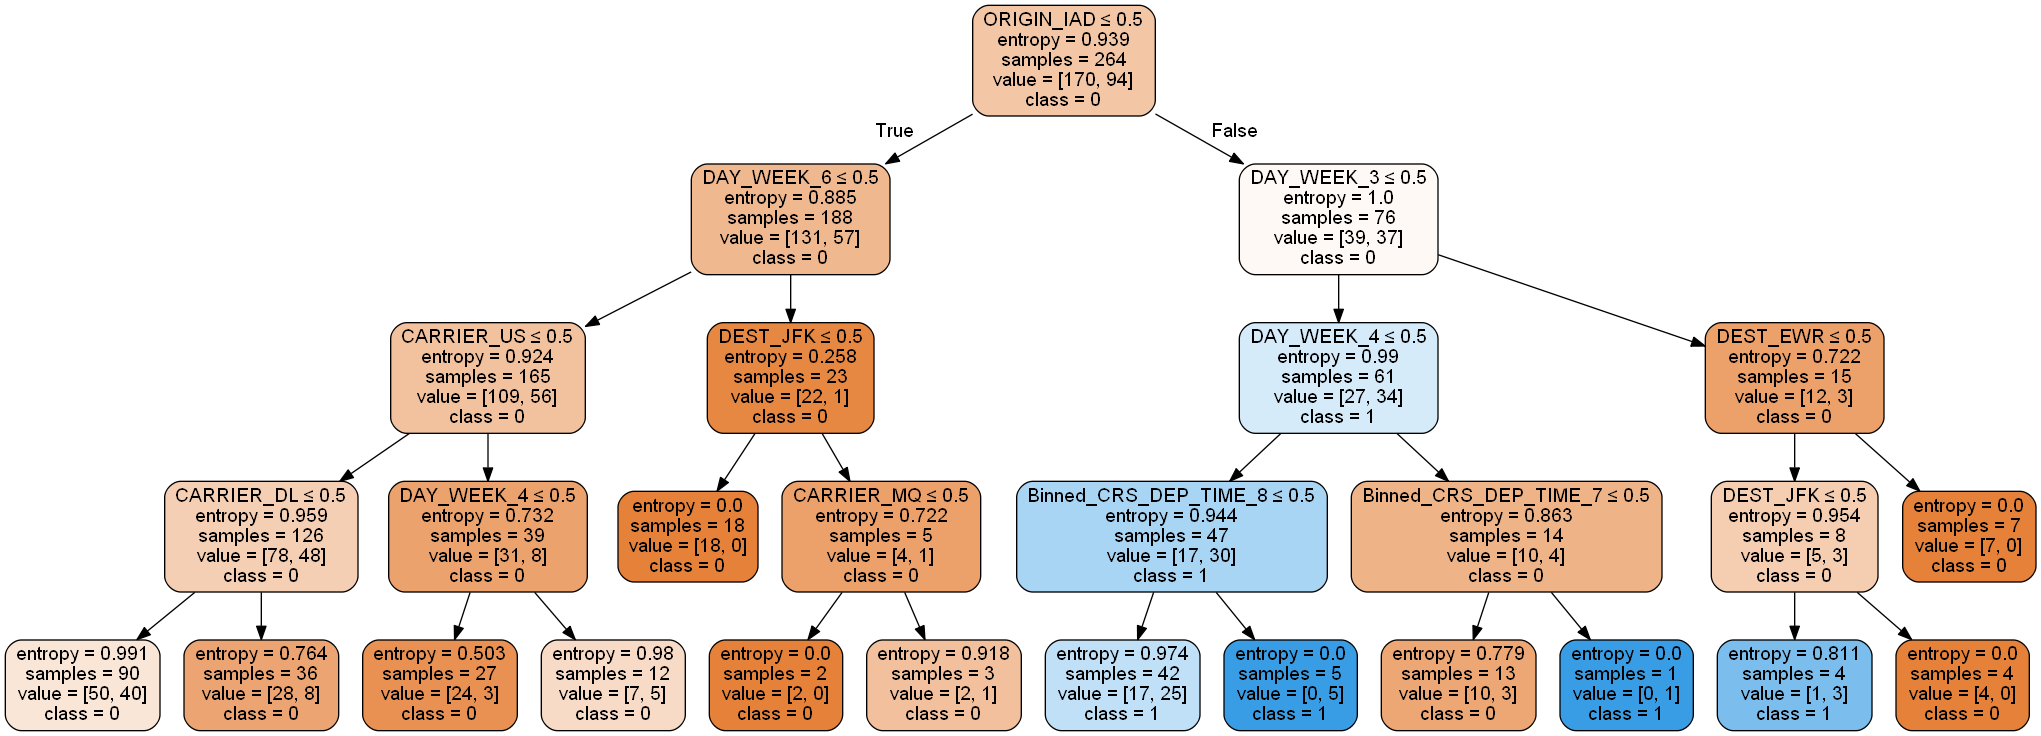

In [14]:
# Separate the predictor values and the DV values into X and y respectively
# Placeholder variable: DV
DV = 'Flight Status_Delayed'
y2 = df_testdata[DV]
X2 = df_testdata.drop(columns=[DV])

# A user-defined function summary_tree to display a classification tree
def summary_tree(model_object):
    dot_data = StringIO()
    export_graphviz(model_object, out_file=dot_data, filled=True,
                  rounded=True, special_characters=True, feature_names=X.columns.values,
                  class_names=['0', '1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    output_imagefile = 'tree.png'
    graph.write_png(output_imagefile)
    return output_imagefile

# Run Classification tree with k-fold cross validation with k=5
# Placeholder variable: kfolds
kfolds = 5

# Here we specify within which range of depths we will search for the best pruned tree
maximum_depth = 8
minimum_depth = 1

param_grid = {'max_depth': list(range(minimum_depth, maximum_depth+1))}

# Set n_jobs to be -1 to run  on all CPU cores.
# The search criterion is to find the model that maximizes whatever the scoring function - for this case roc_auc - returns.
gridsearch2 = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=1), param_grid, scoring='roc_auc', cv=kfolds, n_jobs=-1)
gridsearch2.fit(X2,y2)
clf_BPT2 = gridsearch2.best_estimator_

# Display the level of depth of the best pruned tree
print("The level of depth of the best pruned tree in the test partition is",clf_BPT2.get_depth())

# y_nontest_actual is the actual values of the DV in the validation partition
y_test_actual = df_testdata[DV]

# X_nontest is the predictor values in the validation partition
X_test = df_testdata.drop(columns=[DV])

# Get the AUC of the best pruned tree model in the validation partition
print("The AUC over the test partition is",roc_auc_score(y_test_actual, clf_BPT2.predict_proba(X_test)[:,1]))

# Display the resulting best pruned tree. Notice the capital I
Image(summary_tree(clf_BPT2))